This notebook implements a very simple linear network with pytorch. The dataset used is very small, and only used for some preliminary trials. The dataset is composed of three T1 images (class 0) and three FA images (class 1). The aim of this simple network is to classify images into the two classes. 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms

torch.set_printoptions(edgeitems=2)
torch.manual_seed(0)

In [2]:
#mount the drive folder
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/work/my_tests

Mounted at /content/drive
/content/drive/My Drive/work/my_tests


In [3]:
#load the dataset as an instance of the class customDataset
import os
from customDataset import HCPanatDataset

img_dir = 'HCP-anat-data/images/'
dataset = HCPanatDataset(csv_file='HCP-anat-data/annotations.csv', root_dir=img_dir)

Training on device cpu.


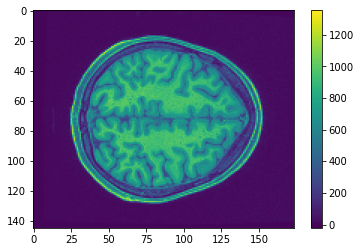

In [4]:
#visualize an example of T1 (class 0)
t1, _ = dataset[0]
im=plt.imshow(t1[:,:,88])
plt.colorbar(im)

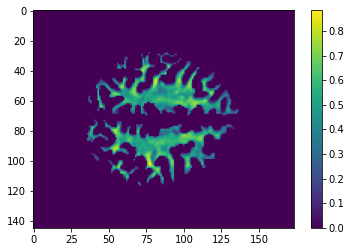

In [5]:
#visualize an example of FA (class 1)
fa, _ = dataset[3]
im=plt.imshow(fa[:,:,88])
plt.colorbar(im)

In [6]:
#transform in torch tensor with transforms.ToTensor()
dataset_t = HCPanatDataset(csv_file='HCP-anat-data/annotations.csv', root_dir=img_dir, transform=transforms.ToTensor())

Normalize the data so they have mean=0 and std=1. This is usually a crucial step.

In [7]:
#compute the mean and std of the data
max_dim = len(t1.shape) #concatenating dimension
imgs = torch.stack([img_t for img_t, _ in dataset_t], dim=max_dim)
mean = torch.mean(imgs)
std = torch.std(imgs)

In [8]:
#normalize the data
transformed_dataset = HCPanatDataset(
    csv_file='HCP-anat-data/annotations.csv', 
    root_dir=img_dir, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean,std)]))

In [9]:
#split the dataset into training and test sets with torch.utils.data.random_split
from torch.utils.data import random_split
N = len(transformed_dataset)
perc_train = 0.8
train_set, test_set = random_split(transformed_dataset, [int(perc_train*N), N-int(perc_train*N)]) 
print("Total number of images: %i" %N)
print("Number of training images: %i" %(perc_train*N))
print("Number of test images: %i" %(N-int(perc_train*N)))

Total number of images: 6
Number of training images: 4
Number of test images: 2


In [10]:
#define the model with nn.Linear(n_in, n_out)
import torch.nn as nn
n_in = imgs.shape[0] * imgs.shape[1] * imgs.shape[2] #number of input features
n_out = 2 #number of output features, i.e. number of classes
linear_model = nn.Linear(n_in, n_out)
print("The number of input feature is: %i" %n_in)

The number of input feature is: 3658350


In [13]:
#define hyperparameters
n_epochs = 30
batch_size = 1

#split the datasets into batches
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [14]:
#define the optimizer (SGD) and the loss (NLL)
import torch.optim as optim
optimizer = optim.SGD(linear_model.parameters(), lr=1e-3)
loss = nn.NLLLoss()

#define the training loop (one batch at the time)
def training_loop(model, train_loader, criterion, optimizer, n_epochs):
  "Training loop with only training loss"
  for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

In [15]:
#training
training_loop(
    model = linear_model,
    train_loader = train_loader,
    criterion = loss,
    optimizer = optimizer,
    n_epochs = n_epochs)

Epoch: 0, Loss: -4549.538086
Epoch: 1, Loss: -14918.478516
Epoch: 2, Loss: -26864.076172
Epoch: 3, Loss: -6381.578125
Epoch: 4, Loss: -49178.324219
Epoch: 5, Loss: -56394.265625
Epoch: 6, Loss: -11852.685547
Epoch: 7, Loss: -13673.398438
Epoch: 8, Loss: -15497.172852
Epoch: 9, Loss: -97869.539062
Epoch: 10, Loss: -116121.484375
Epoch: 11, Loss: -20967.482422
Epoch: 12, Loss: -138436.281250
Epoch: 13, Loss: -139345.937500
Epoch: 14, Loss: -160750.156250
Epoch: 15, Loss: -160082.937500
Epoch: 16, Loss: -170452.015625
Epoch: 17, Loss: -194221.703125
Epoch: 18, Loss: -191189.328125
Epoch: 19, Loss: -35563.250000
Epoch: 20, Loss: -37386.316406
Epoch: 21, Loss: -238849.953125
Epoch: 22, Loss: -41024.136719
Epoch: 23, Loss: -243036.437500
Epoch: 24, Loss: -44675.195312
Epoch: 25, Loss: -46489.609375
Epoch: 26, Loss: -294642.937500
Epoch: 27, Loss: -50141.882812
Epoch: 28, Loss: -294887.750000
Epoch: 29, Loss: -53788.707031


In [16]:
#check accuracy
def check_accuracy(loader, model):

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for imgs, labels in loader:
      outputs = model(imgs.view(imgs.shape[0], -1))
      _, predicted = torch.max(outputs, dim=1)
      total += labels.shape[0]
      correct += int((predicted == labels).sum())
        
  print("Accuracy: %f" % (correct / total))

In [17]:
#compute accuracy in training
check_accuracy(train_loader, linear_model)

Accuracy: 1.000000


In [18]:
#compute accuracy in test
check_accuracy(test_loader, linear_model)

Accuracy: 1.000000
